In [3]:
# importing the libraries
import numpy as np
import nltk
import re
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer 
import heapq
import json
import pandas as pd
from IPython.display import display
import time
import random

In [5]:
def import_data(corpus_jsonl):
    corpus = []
    with open(corpus_jsonl) as f:
        for line in f:
            data = json.loads(line)
            corpus += [data["text"]]
    return corpus

In [6]:
corpus = import_data('corpus.jsonl')

In [7]:
from numpy.linalg import norm
def Cosine(a: np.ndarray, b: np.ndarray):
    return a.dot(b)/(norm(a, ord=2)*norm(b, ord=2))


In [8]:
def sparse_representation(corpus):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)
    return tfidf_matrix.toarray()

# SEQUENTIAL

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_all_pairs_similarity(matrix, T):
    
    # Compute cosine similarity between all pairs
    similarity_matrix = cosine_similarity(matrix, matrix)
    
    # Extract similarity scores for all pairs
    pairs = [(i, j, similarity_matrix[i][j]) for i in range(len(matrix)) for j in range(i + 1, len(matrix))]
    
    similarity_results = np.array(pairs)
    
    result = similarity_results[similarity_results[:, 2] >= T]
    
    return result



# SPARK VERSION

In [10]:
def boundary_document(document, T, max_document):    
    return next((term for term in reversed(range(len(document))) if np.dot(document[:term], max_document[:term]) < T), 0)



In [11]:
def map_function(id_document, boundary_arr):
    result = []
    
    id_ = int(id_document[0])
    document = id_document[1:]
    boundary = boundary_arr[id_]
    for term in range(boundary+1,len(document)+1):
        if id_document[term] != 0 and boundary!=len(document)+1:
            result += (term, (id_, document))
    return result

In [12]:
def reduce_function(x, T):
    key = x[0]
    list_of_documents = list(x[1])
    result = []  
    
    for i in range(len(list_of_documents)):
        for j in range(i+1,len(list_of_documents)): #to not have pairs
            d1 = list_of_documents[i] 
            d2 = list_of_documents[j]
            union_terms = np.union1d(np.nonzero(d1[1]), np.nonzero(d2[1]))
            if key == np.max(union_terms):
                similarity = np.dot(d1[1], d2[1])
                if similarity >= T:
                    result += [(d1[0],d2[0],similarity)]    
   
    return result

In [13]:
def pairs_similarity_spark(matrix, bd_array, T, sc, slice_):

    documents_rdd = sc.parallelize(matrix, slice_)
    # Map the RDD to term-document pairs
    pairs = documents_rdd.flatMap(lambda x: map_function(x, bd_array))\
                .groupByKey()\
                .flatMap(lambda x: reduce_function(x, T))\
                .collect()

    return pairs

# TESTS

In [14]:
LEN = 750
threshold = 0.9

# Create a TF-IDF matrix
sparse_r = sparse_representation(corpus)[:LEN, :]
pd.DataFrame(sparse_r)

,0,1,2,3,4,5,6,7,8,9,...,26015,26016,26017,26018,26019,26020,26021,26022,26023,26024
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.051283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
746,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
747,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
748,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3> SEQUENTIAL TEST

In [15]:
sequential_execution = []

# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = compute_all_pairs_similarity(sparse_r, threshold)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

0.46483445167541504


In [16]:
pd.DataFrame(result_sequential)

,0,1,2
0,27.0,32.0,1.0


<h3> SPARK TEST

In [17]:
from pyspark.sql import SparkSession
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext, SparkConf
import os
import sys

python_v = sys.executable
os.environ['PYSPARK_PYTHON'] = python_v
os.environ['PYSPARK_DRIVER_PYTHON'] = python_v





In [18]:
column_sums = np.sum(sparse_r, axis=0) #sum of all columns
sorted_indices = np.argsort(column_sums) #sort by the sum of the columns

# Rearrange the columns based on the sorted indices
matrix_sorted = sparse_r[:, sorted_indices]

#document with all the max term-freq
max_document = np.max(matrix_sorted, axis=0)

# Creating an index column
index_column = np.arange(matrix_sorted.shape[0]).reshape(-1, 1)
# Adding the index column to the matrix
matrix = np.hstack((index_column, matrix_sorted)) #in this way I save the document Id  

#calculate the boundary for each document and save into an array
bd_array = [boundary_document(matrix_sorted[i], threshold , max_document ) for i in range(len(matrix_sorted))]

In [19]:
bd_array

[25628,
 25719,
 25782,
 24989,
 24788,
 25243,
 25301,
 25301,
 25076,
 25076,
 25658,
 24899,
 25432,
 25402,
 25128,
 25071,
 25462,
 25135,
 24984,
 25462,
 24594,
 24965,
 25386,
 25555,
 25390,
 25325,
 25601,
 25287,
 25287,
 24331,
 25287,
 25545,
 25287,
 24973,
 25353,
 25421,
 24999,
 25458,
 25117,
 24982,
 24672,
 24734,
 25483,
 24307,
 25418,
 24938,
 25060,
 25397,
 25223,
 25637,
 25807,
 24985,
 25084,
 25421,
 24782,
 25740,
 25874,
 25496,
 25221,
 25421,
 25176,
 25748,
 25371,
 25692,
 25501,
 25695,
 25906,
 25707,
 25437,
 25765,
 25754,
 25796,
 25143,
 25803,
 25143,
 24927,
 25672,
 25639,
 25417,
 25501,
 25819,
 25600,
 25255,
 25119,
 24422,
 25717,
 24782,
 25108,
 24761,
 23687,
 25095,
 25572,
 24825,
 25654,
 25284,
 25022,
 24841,
 25576,
 24455,
 24341,
 25303,
 25229,
 25203,
 24923,
 25137,
 24665,
 25430,
 24622,
 24859,
 24578,
 24651,
 25445,
 25692,
 25554,
 25538,
 25617,
 25617,
 25113,
 25000,
 25462,
 25656,
 25497,
 25211,
 24778,
 24790,


<h5> One Single Example

In [20]:
spark = SparkSession.builder\
        .appName("Documents all Pairs Similarity")\
        .master("local[8]")\
        .getOrCreate()
    
sc = spark.sparkContext    

# Measure the execution time
start_time = time.time()

# Call the function
result_spark = pairs_similarity_spark(matrix, bd_array, threshold, sc, 16)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time


print(elapsed_time)

635.28182721138


In [21]:
pd.DataFrame(result_spark)

,0,1,2
0,27,32,1.0


In [22]:
sc.stop()

<h5> Using different number of works : [1, 2, 4, 6, 8, 10, 12, 16]

In [28]:
execution_time = [2205.729660511017]

In [29]:
# 1 worker
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[1]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc, 2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

#save the time
execution_time += [elapsed_time]

sc.stop()

print(execution_time)

2205.729660511017


In [30]:
# 2 workers
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[2]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc,2*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

#save the time
execution_time += [elapsed_time]

sc.stop()

print(execution_time)

[2205.729660511017, 1074.9825179576874]


In [31]:
# 4 workers
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[4]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc, 4*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

#save the time
execution_time += [elapsed_time]

sc.stop()

print(execution_time)

[2205.729660511017, 1074.9825179576874, 764.0852315425873]


In [32]:
# 6 workers
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[6]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc, 6*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

#save the time
execution_time += [elapsed_time]

sc.stop()

print(execution_time)

[2205.729660511017, 1074.9825179576874, 764.0852315425873, 657.8605923652649]


In [33]:
# 10 workers
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[10]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc, 10*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

#save the time
execution_time += [elapsed_time]

sc.stop()

print(execution_time)

[2205.729660511017, 1074.9825179576874, 764.0852315425873, 657.8605923652649, 638.109103679657]


In [2]:
execution_time = [2205.729660511017, 1074.9825179576874, 764.0852315425873, 657.8605923652649, 635.28182721138, 638.109103679657]

In [20]:
# 12 workers
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[12]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc, 12*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

#save the time
execution_time += [elapsed_time]

sc.stop()

print(execution_time)

[2205.729660511017, 1074.9825179576874, 764.0852315425873, 657.8605923652649, 635.28182721138, 638.109103679657, 629.6595883369446]


In [23]:
# 16 workers
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[16]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc, 16*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

#save the time
execution_time += [elapsed_time]

sc.stop()

print(execution_time)

[2205.729660511017, 1074.9825179576874, 764.0852315425873, 657.8605923652649, 635.28182721138, 638.109103679657, 629.6595883369446, 644.642744064331]


In [4]:
np.divide(np.full((1, 8), execution_time[0]), execution_time)

array([[1.        , 2.05187491, 2.88675866, 3.3528831 , 3.47204904,
        3.4566654 , 3.50305102, 3.4216311 ]])

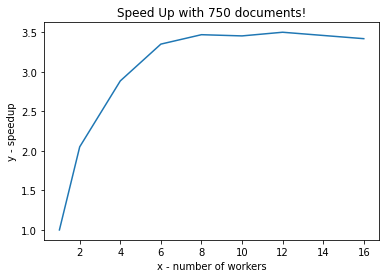

In [8]:
# importing the required module
import matplotlib.pyplot as plt

# x axis values
y = np.divide(np.full((1, 8), execution_time[0]), execution_time)[0]
# corresponding y axis values
x = [1, 2, 4, 6, 8, 10, 12, 16]

# plotting the points
plt.plot(x, y)

# naming the x axis
plt.xlabel('x - number of workers')
# naming the y axis
plt.ylabel('y - speedup')

# giving a title to my graph
plt.title('Speed Up with 750 documents!')

# function to show the plot
plt.show()
